In [1]:
# install any additional packages
!pip install pycountry
!pip install geopandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 48.7 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=8587168a28a4bb92f64c6c9fe8398a6757c712ba04463db4d2c208dc2ec37b6e
  Stored in directory: /root/.cache/pip/wheels/e9/43/d9/de0427ef97aeac94f853545b02a8c07661abe1f44b64a0266d
Successfully built pycountry


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import pycountry 
import geopandas
from geopandas import GeoDataFrame
import seaborn as sns
import plotly.express as px

# styling 
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/layoffs-data-2022/layoffs_data.csv


In [4]:
original_data = pd.read_csv('/kaggle/input/layoffs-data-2022/layoffs_data.csv')
# lowering column names to avoid typo errors
original_data.columns = original_data.columns.str.lower() 
# display first 2 rows
original_data.head(2).style.background_gradient(axis=None) 

,company,location_hq,industry,laid_off_count,percentage,date,source,funds_raised,stage,date_added,country,list_of_employees_laid_off
0,Thoughtworks,Chicago,Other,500.000000,0.040000,2023-03-01 00:00:00,https://techcrunch.com/2023/03/01/thoughtworks-layoffs-economic-slowdown/,748.000000,Post-IPO,2023-03-02 04:06:16,United States,Unknown
1,iFood,Sao Paulo,Food,355.000000,0.060000,2023-03-01 00:00:00,https://economia.uol.com.br/noticias/redacao/2023/03/01/ifood-demissao-funcionarios.htm,2100.000000,Subsidiary,2023-03-02 04:13:25,Brazil,Unknown


In [5]:
data = original_data.copy()
data.head().style.background_gradient(axis=None) 

,company,location_hq,industry,laid_off_count,percentage,date,source,funds_raised,stage,date_added,country,list_of_employees_laid_off
0,Thoughtworks,Chicago,Other,500.000000,0.040000,2023-03-01 00:00:00,https://techcrunch.com/2023/03/01/thoughtworks-layoffs-economic-slowdown/,748.000000,Post-IPO,2023-03-02 04:06:16,United States,Unknown
1,iFood,Sao Paulo,Food,355.000000,0.060000,2023-03-01 00:00:00,https://economia.uol.com.br/noticias/redacao/2023/03/01/ifood-demissao-funcionarios.htm,2100.000000,Subsidiary,2023-03-02 04:13:25,Brazil,Unknown
2,Waymo,SF Bay Area,Transportation,209.000000,0.080000,2023-03-01 00:00:00,https://www.theinformation.com/articles/alphabets-robotaxi-unit-waymo-says-it-laid-off-8,5500.000000,Subsidiary,2023-03-02 04:08:34,United States,Unknown
3,PayFit,Paris,HR,200.000000,0.200000,2023-03-01 00:00:00,https://www.lesechos.fr/start-up/next40-vivatech/payfit-se-separe-de-20-de-ses-effectifs-1910932,495.000000,Series E,2023-03-02 04:17:47,France,Unknown
4,Yellow.ai,SF Bay Area,Support,200.000000,nan,2023-03-01 00:00:00,https://inc42.com/buzz/conversational-ai-startup-yellow-ai-fires-200-employees/,102.000000,Series C,2023-03-02 04:12:23,United States,Unknown


## <font color = "Blue"> Pre Processing </font>

#### <font color = "Green"> Data Cleaning </font>

##### <font color = "Blue"> Datatype conversions </font>

In [6]:
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
data['date_added'] = pd.to_datetime(data['date_added'], infer_datetime_format=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   company                     2330 non-null   object        
 1   location_hq                 2330 non-null   object        
 2   industry                    2330 non-null   object        
 3   laid_off_count              1600 non-null   float64       
 4   percentage                  1561 non-null   float64       
 5   date                        2329 non-null   datetime64[ns]
 6   source                      2330 non-null   object        
 7   funds_raised                2126 non-null   float64       
 8   stage                       2330 non-null   object        
 9   date_added                  2330 non-null   datetime64[ns]
 10  country                     2330 non-null   object        
 11  list_of_employees_laid_off  2329 non-null   object      

##### <font color = "Blue"> Missing value treatment </font>

In [7]:
print("Total records in dataframe -", len(data))
print("Nulls stats - ")
data.isnull().sum()

Total records in dataframe - 2330
Nulls stats - 


company                         0
location_hq                     0
industry                        0
laid_off_count                730
percentage                    769
date                            1
source                          0
funds_raised                  204
stage                           0
date_added                      0
country                         0
list_of_employees_laid_off      1
dtype: int64

In [8]:
# Replace NaN with O -
data['laid_off_count'] = data['laid_off_count'].replace(np.NaN, 0)
data['percentage'] = data['percentage'].replace(np.NaN, 0)
data['funds_raised'] = data['funds_raised'].replace(np.NaN, 0)

# Replace missing date with date added
data['date'] = data['date'].fillna(data['date_added'])

# check for nulls - 
print("Nulls stats - ")
data.isnull().sum()

Nulls stats - 


company                       0
location_hq                   0
industry                      0
laid_off_count                0
percentage                    0
date                          0
source                        0
funds_raised                  0
stage                         0
date_added                    0
country                       0
list_of_employees_laid_off    1
dtype: int64

##### <font color = "Blue"> Remove unwanted columns </font>

In [9]:
columns_to_be_dropped = ['source', 'date_added', 'list_of_employees_laid_off']
data = data.drop(columns_to_be_dropped, axis=True)
data.columns.values

array(['company', 'location_hq', 'industry', 'laid_off_count',
       'percentage', 'date', 'funds_raised', 'stage', 'country'],
      dtype=object)

#### <font color = "Green"> Build additional columns for EDA </font>

In [10]:
data['month'] = data['date'].dt.strftime('%b')
data['year'] = data['date'].dt.year
data['month_year'] = data['date'].dt.to_period('M')
data['quarter'] = pd.PeriodIndex(pd.to_datetime(data.date), freq='Q')
data.head(2)

,company,location_hq,industry,laid_off_count,percentage,date,funds_raised,stage,country,month,year,month_year,quarter
0,Thoughtworks,Chicago,Other,500.0,0.04,2023-03-01,748.0,Post-IPO,United States,Mar,2023,2023-03,2023Q1
1,iFood,Sao Paulo,Food,355.0,0.06,2023-03-01,2100.0,Subsidiary,Brazil,Mar,2023,2023-03,2023Q1


##### <font color = "Blue"> Logic for world map </font>

In [11]:
def get_country_code(column):
    country_code=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            country_code.append(code)
        except:
            country_code.append('None')
    return country_code

In [12]:
# create a geo df 
geo_df = data.groupby(['country'], as_index=False)["laid_off_count"].sum()

# create a column for country_code 
geo_df['country_code'] = get_country_code(geo_df.country)
geo_df.head(2)

,country,laid_off_count,country_code
0,Argentina,323.0,ARG
1,Australia,1724.0,AUS


In [13]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns=['pop_est', 'continent', 'name', 'country_code', 'gdp_md_est', 'geometry']
world.head(2)

,pop_est,continent,name,country_code,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."


In [14]:
geo_df = pd.merge(geo_df, world, how ="left", on='country_code')
geo_df.head(2)
columns_to_be_dropped = ['pop_est', 'gdp_md_est', 'name']
geo_df = geo_df.drop(columns_to_be_dropped, axis=True)
print(geo_df.columns.values)
print(geo_df.shape)

['country' 'laid_off_count' 'country_code' 'continent' 'geometry']
(59, 5)


In [15]:
# Error :- AttributeError: 'Line2D' object has no property 'column'
# Solution :- Converting the final dataframe into a geodataframe

geo_df = GeoDataFrame(geo_df)

geo_df.head(3)

,country,laid_off_count,country_code,continent,geometry
0,Argentina,323.0,ARG,South America,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."
1,Australia,1724.0,AUS,Oceania,"MULTIPOLYGON (((147.68926 -40.80826, 148.28907..."
2,Austria,570.0,AUT,Europe,"POLYGON ((16.97967 48.12350, 16.90375 47.71487..."


## <font color = "Blue"> Exploratory data analysis (EDA)  </font>

##### <font color = "Green">  Statistics related to employee layoffs w.r.t geographical location</font>

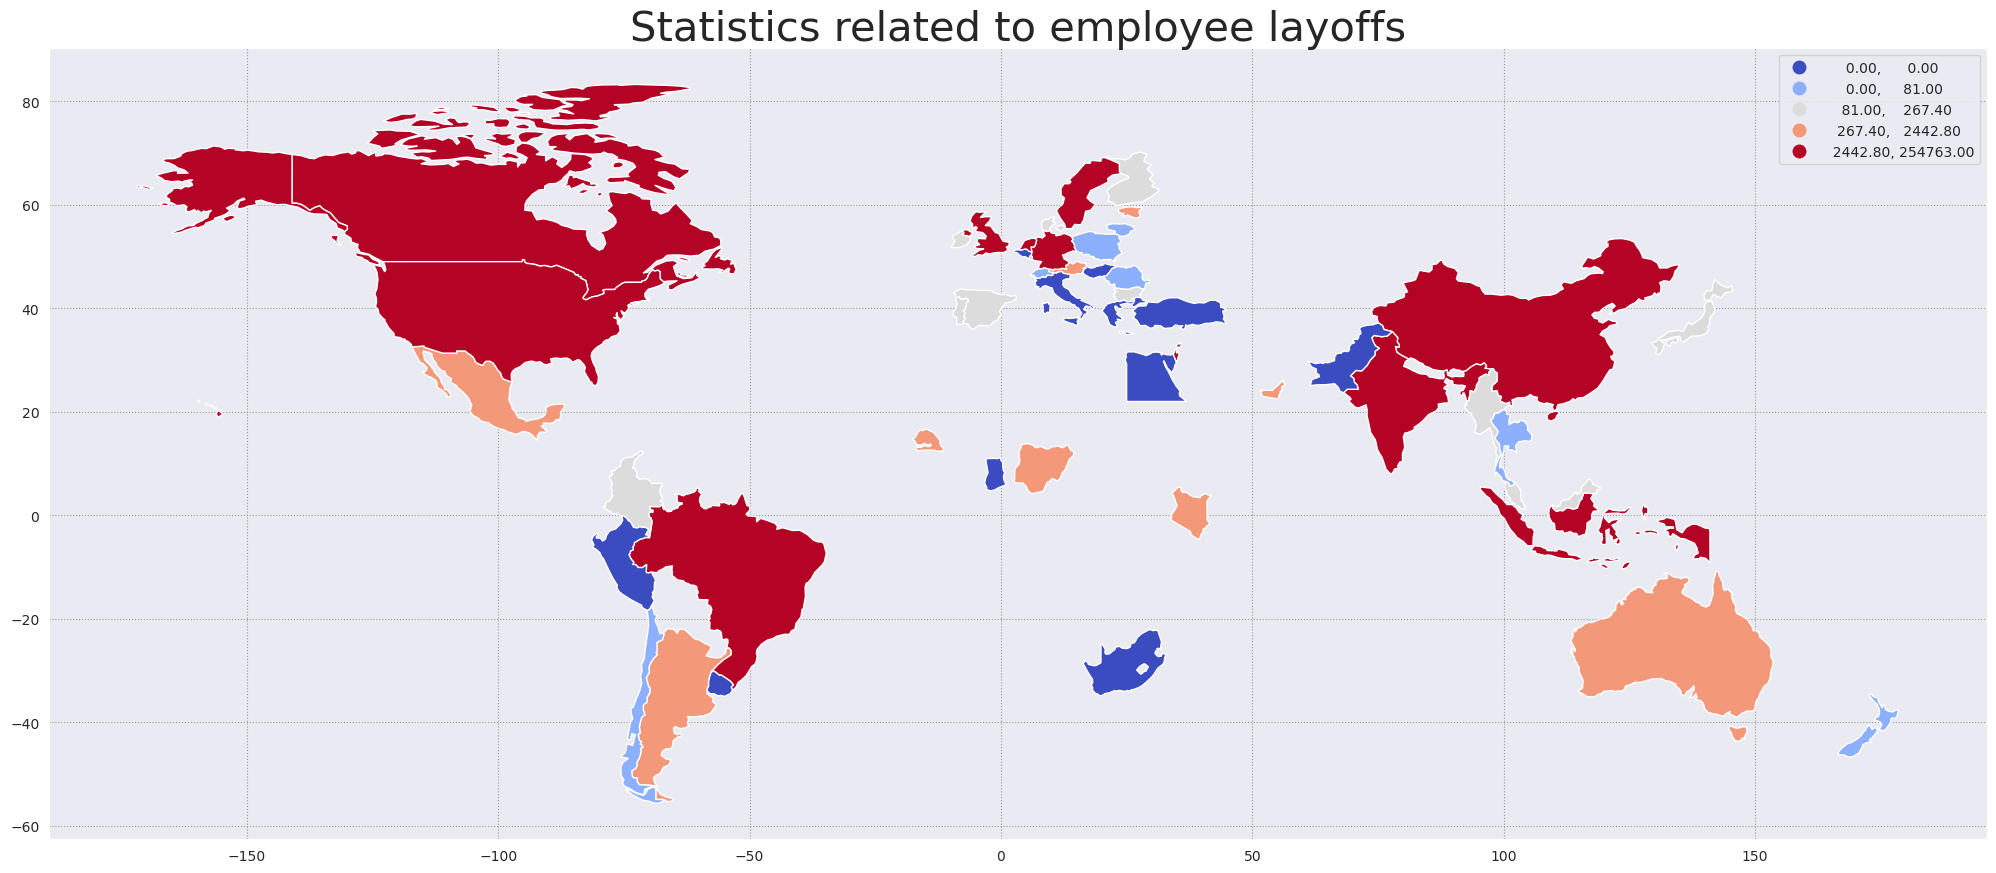

In [16]:
geo_df.plot(column='laid_off_count', 
                scheme="quantiles",
                figsize=(25, 20),
                legend=True,
                cmap='coolwarm' # coolwarm, inferno, hsv, Oranges_r, Blues
           )

# plt.rcParams["figure.autolayout"] = True

""" 
Ps :- I tried to increase size of legends and seems it's not working. 
May be I am missing something.
"""

# plt.legend(['blue', 'orange', 'green', 'red', 'grey'],
#            prop = {'size' : 100},
#            loc = 'upper left', shadow = True,
#            facecolor = 'yellow')

plt.title('Statistics related to employee layoffs',fontsize=30)

plt.show()

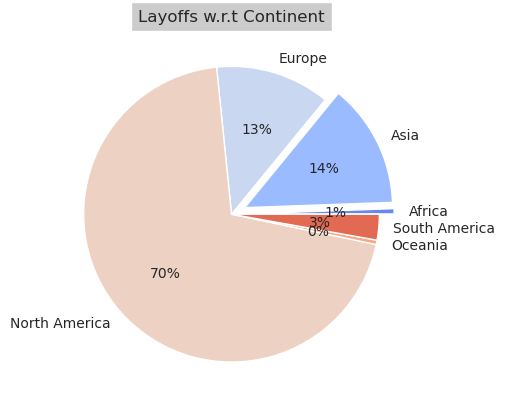

In [17]:
temp_df = geo_df.groupby(['continent'], as_index=False)["laid_off_count"].sum()

# declaring exploding pie
explode = [0.1, 0.1, 0, 0, 0, 0]

palette_color = sns.color_palette('coolwarm')

plt.pie(temp_df['laid_off_count'], 
        labels = temp_df['continent'], 
        colors = palette_color, 
        explode=explode,
        autopct='%.0f%%')

plt.title("Layoffs w.r.t Continent", 
          bbox={'facecolor':'0.8', 'pad':5})

plt.show()

##### <font color = "Green">  Statistics related to employee layoffs w.r.t timeline(dates) </font>

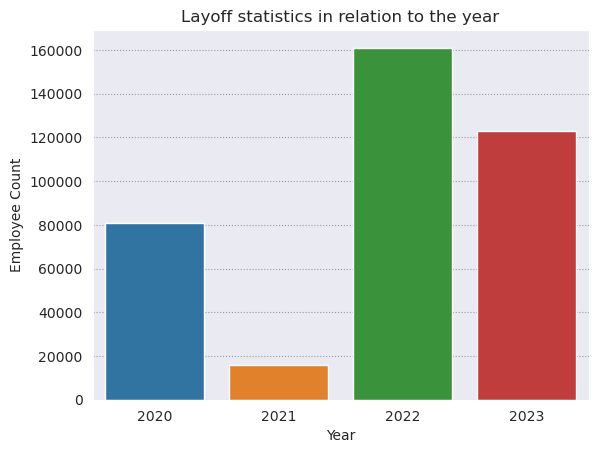

In [18]:
ax = sns.barplot(x="year",
            y="laid_off_count",
            errorbar=('ci', 0),
            data=data,
            estimator=sum
           )

ax.set(xlabel='Year', ylabel='Employee Count', 
       title= "Layoff statistics in relation to the year")
plt.show()


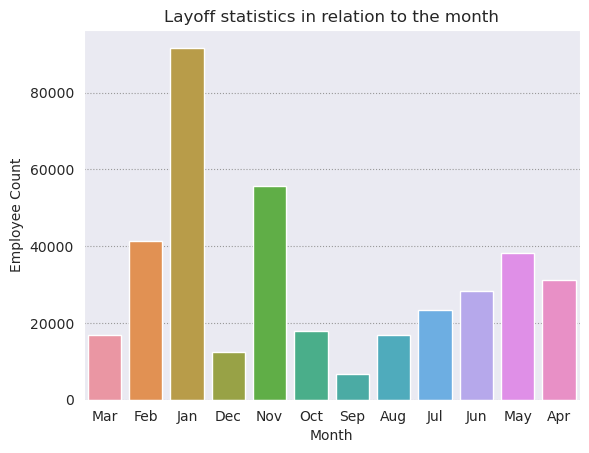

In [19]:
ax = sns.barplot(x="month",
            y="laid_off_count",
            errorbar=('ci', 0),
            data=data,
            estimator=sum
           )

ax.set(xlabel='Month', ylabel='Employee Count', 
       title= "Layoff statistics in relation to the month")
plt.show()

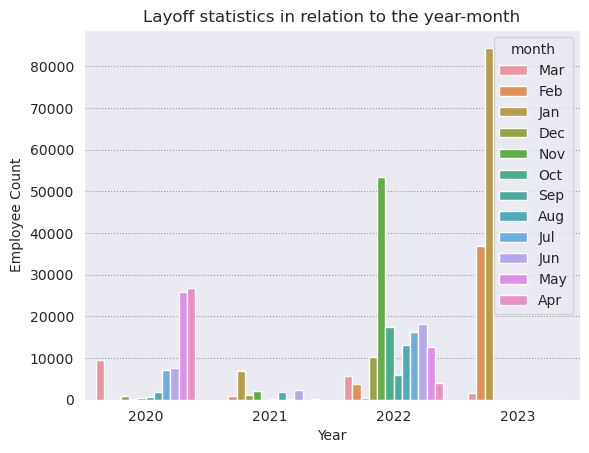

In [20]:
ax = sns.barplot(x="year",
            y="laid_off_count",
            hue="month",     
            errorbar=('ci', 0),
            data= data,
            estimator=sum,            
            #log=True,
           )

ax.set(xlabel='Year', ylabel='Employee Count', 
       title= "Layoff statistics in relation to the year-month")
plt.show()

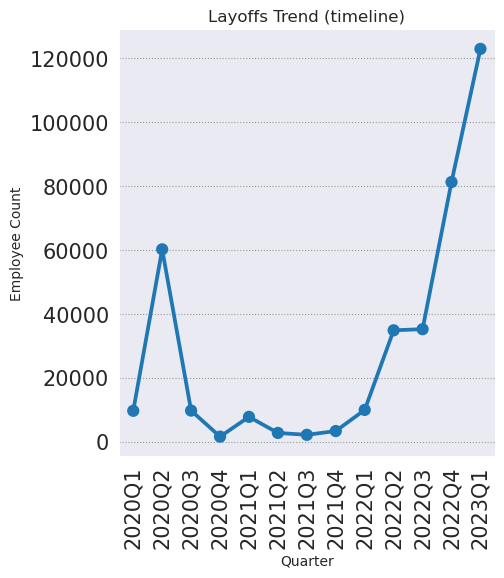

In [21]:

ax = sns.catplot(x="quarter", 
                 y="laid_off_count", 
                 errorbar=('ci', 0),
                 #data=data,
                 data=data.sort_values(by=['quarter'], ascending=True),
                 estimator=sum,
                 kind='point')

ax.set(xlabel='Quarter', ylabel='Employee Count', 
       title= "Layoffs Trend (timeline)")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.show()

##### <font color = "Green"> Statistics related to employee layoffs (For Top N  records) </font>

In [22]:
""" PS :- you can configure this parameter to set the number of records you want 
to view. No need to change in other places.
"""
top_n = 10

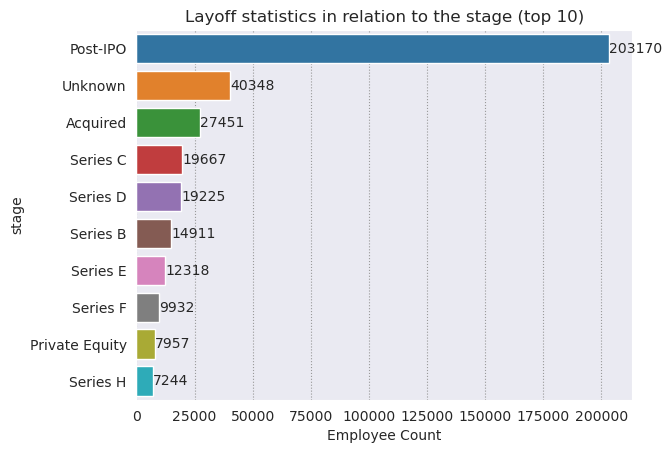

In [23]:
temp_df = data.groupby(['stage'], as_index=False)["laid_off_count"].sum()

temp_df = temp_df.sort_values(by=['laid_off_count'], ascending=False)

ax = sns.barplot(y="stage",
            x="laid_off_count",
            errorbar=('ci', 0),
            data= temp_df.head(top_n),
            estimator=sum,
            dodge=False
           )
for container in ax.containers:
    ax.bar_label(container,padding=0)
    
ax.set(xlabel='Employee Count', ylabel='stage', 
       title= "Layoff statistics in relation to the stage (top {})".format(top_n))
plt.show()

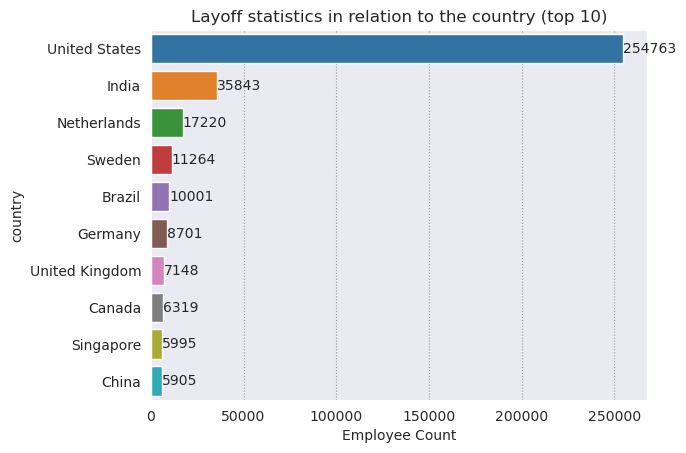

In [24]:
temp_df = data.groupby(['country'], as_index=False)["laid_off_count"].sum()

temp_df = temp_df.sort_values(by=['laid_off_count'], ascending=False)

ax = sns.barplot(y="country",
            x="laid_off_count",
            errorbar=('ci', 0),
            data= temp_df.head(top_n),
            estimator=sum,
           )

for container in ax.containers:
    ax.bar_label(container,padding=0)
    
ax.set(ylabel='country', xlabel='Employee Count', 
       title= "Layoff statistics in relation to the country (top {})".format(top_n))
plt.show()

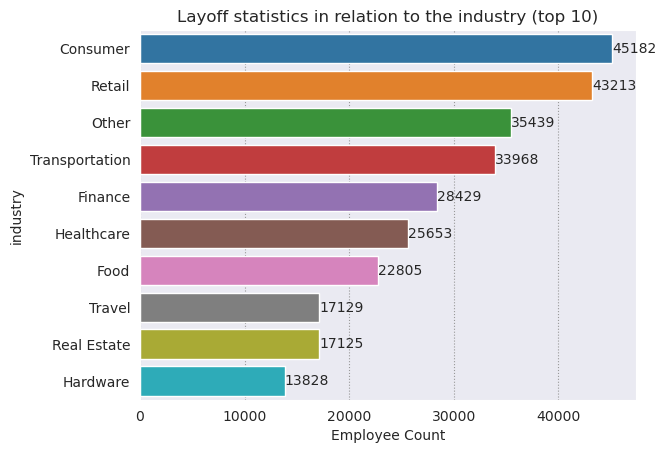

In [25]:
temp_df = data.groupby(['industry'], as_index=False).sum()

temp_df = temp_df.sort_values(by=['laid_off_count'], ascending=False)

ax = sns.barplot(y="industry",
            x="laid_off_count",
            errorbar=('ci', 0),
            data= temp_df.head(top_n),
            estimator=sum,
           )

for container in ax.containers:
    ax.bar_label(container,padding=0)
    
ax.set(ylabel='industry', xlabel='Employee Count', 
       title= "Layoff statistics in relation to the industry (top {})".format(top_n))
plt.show()

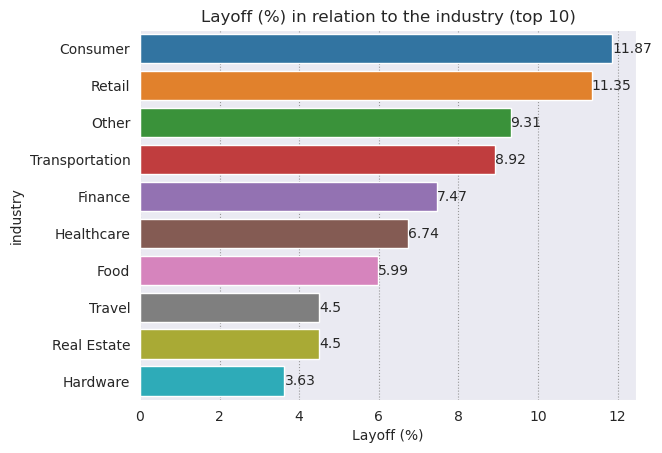

In [26]:
#temp_df.laid_off_count.sum()
temp_df["layoff_percent"] = round(temp_df["laid_off_count"] / temp_df.laid_off_count.sum() * 100,2)

ax = sns.barplot(y="industry",
            x="layoff_percent",
            errorbar=('ci', 0),
            data= temp_df.head(top_n),
            estimator=sum,
           )

for container in ax.containers:
    ax.bar_label(container,padding=0)
    
ax.set(ylabel='industry', xlabel='Layoff (%)', 
       title= "Layoff (%) in relation to the industry (top {})".format(top_n))
plt.show()



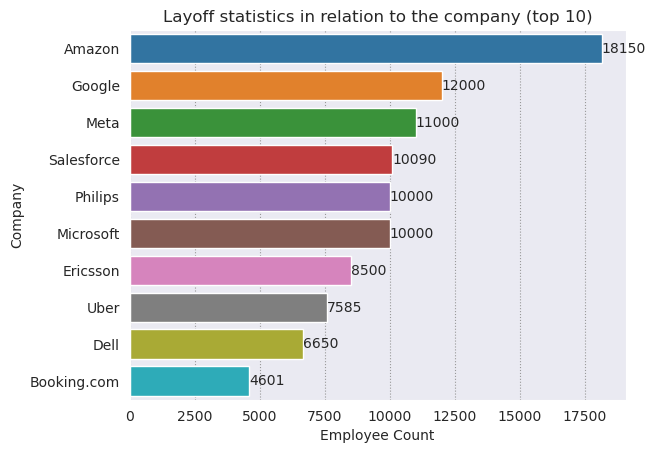

In [27]:
temp_df = data.groupby(['company'], as_index=False)["laid_off_count"].sum()

temp_df = temp_df.sort_values(by=['laid_off_count'], ascending=False)

ax = sns.barplot(y="company",
            x="laid_off_count",
            errorbar=('ci', 0),
            data= temp_df.head(top_n),
            estimator=sum,
            orient='h'     
           )

for container in ax.containers:
    ax.bar_label(container,padding=0)
    
    
ax.set(xlabel='Employee Count', ylabel='Company', 
       title= "Layoff statistics in relation to the company (top {})".format(top_n))
plt.show()

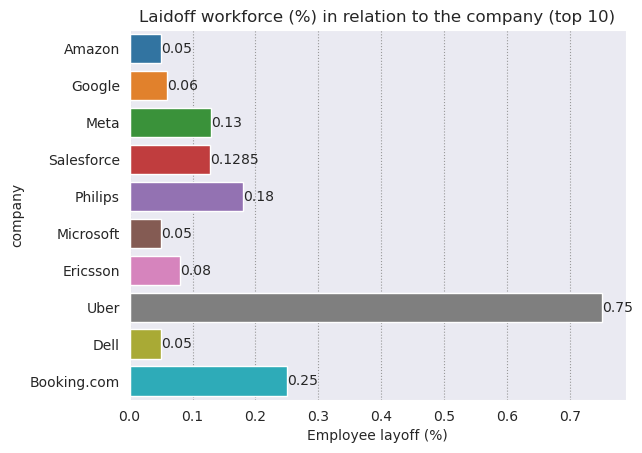

In [28]:
temp_df = data.groupby(['company'], as_index=False).sum()

temp_df = temp_df.sort_values(by=['laid_off_count'], ascending=False)

ax = sns.barplot(y="company",
            x="percentage",
            errorbar=('ci', 0),
            data= temp_df.head(top_n),
            estimator=sum,
            orient='h'             
           )

for container in ax.containers:
    ax.bar_label(container,padding=0)
    
    
ax.set(ylabel='company', xlabel='Employee layoff (%)', 
       title= "Laidoff workforce (%) in relation to the company (top {})".format(top_n))
plt.show()

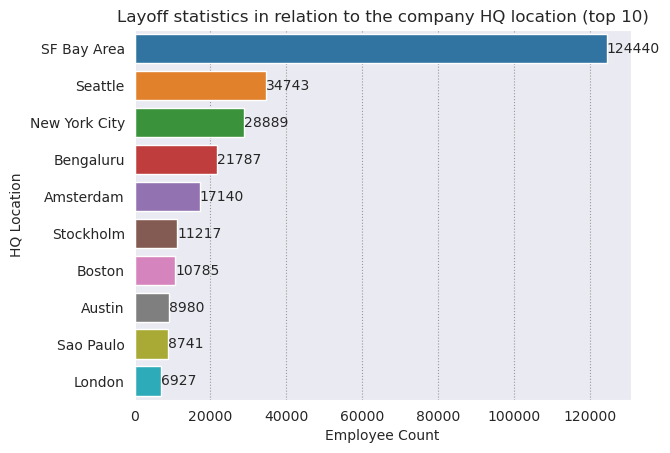

In [29]:
temp_df = data.groupby(['location_hq'], as_index=False).sum()

temp_df = temp_df.sort_values(by=['laid_off_count'], ascending=False)

ax = sns.barplot(y="location_hq",
            x="laid_off_count",
            errorbar=('ci', 0),
            data= temp_df.head(top_n),
            estimator=sum,
            orient='h'             
           )

for container in ax.containers:
    ax.bar_label(container,padding=0)
    
    
ax.set(ylabel='HQ Location', xlabel='Employee Count', 
       title= "Layoff statistics in relation to the company HQ location (top {})".format(top_n))
plt.show()

#### <font style="background-color:#abdbe3" color = "black"> *I’m not a great programmer; I’m just a good programmer with great habits. ― Kent Beck.*  <br><br> Happy Learning..!!! </font>